In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
df.head()

,gamePk,home_offense,home_power,home_clutch,home_r_oppBa,home_r_oppBb,home_r_oppEr,home_s_oppBa,home_s_oppBb,home_s_oppEr,away_offense,away_power,away_clutch,away_r_oppBa,away_r_oppBb,away_r_oppEr,away_s_oppBa,away_s_oppBb,away_s_oppEr,homeTeam_win
0,566180,0.363636,0.079365,0.285714,0.163934,0.075758,0.333333,0.258922,0.089009,0.368218,0.315068,0.250000,0.391304,0.253968,0.112676,0.375000,0.258785,0.089063,0.368410,0.0
1,565316,0.220000,0.055556,0.227273,0.230769,0.099010,0.354839,0.258922,0.089009,0.368218,0.321739,0.155340,0.405405,0.218750,0.102804,0.468750,0.258785,0.089063,0.368410,1.0
2,567459,0.412371,0.187500,0.325000,0.240385,0.079646,0.294118,0.258922,0.089008,0.368218,0.254902,0.074074,0.153846,0.176923,0.084507,0.314286,0.258785,0.089063,0.368410,1.0
3,565223,0.238095,0.172414,0.333333,0.223881,0.182927,0.200000,0.258921,0.089010,0.368217,0.335766,0.235294,0.369565,0.237410,0.085526,0.413043,0.258785,0.089064,0.368412,0.0
4,566868,0.246479,0.092308,0.342857,0.155556,0.111842,0.157895,0.258919,0.089009,0.368213,0.300885,0.125000,0.411765,0.277228,0.192000,0.288462,0.258785,0.089063,0.368410,0.0


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_set,test_set = train_test_split(df,test_size=.2,random_state=12,shuffle=True)

In [377]:
X_test = test_set.drop(columns=['homeTeam_win','gamePk'])
y_test = test_set['homeTeam_win']

In [6]:
games = train_set.copy()

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures

In [383]:
def plot_confusion_matrix(true,predicted):
    import itertools
    cm=confusion_matrix(true,predicted)
    classes=['Home Team Loss','Home Team Win']
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,cmap=plt.cm.Blues)
    #plt.title('Confusion matrix',fontdict={'size':20})
    fig.colorbar(cax)
    ax.set_xticklabels([''] + classes,fontdict={'size':14})
    ax.set_yticklabels([''] + classes,fontdict={'size':14})
    plt.xlabel('Predicted',fontdict={'size':14})
    plt.ylabel('True',fontdict={'size':14})
    plt.grid(b=None)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             fontdict={'size':14,'weight':'heavy'},
             color="black" if cm[i, j] > thresh else "black")
    plt.show()
    return fig

In [74]:
def pipeline_cv(splits, X, Y, pipeline):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    
    reports = []
    for train, test in kfold.split(X, Y):
        fit = pipeline.fit(X.iloc[train], Y.iloc[train])
        prediction = fit.predict(X.iloc[test])
        
        reports.append(
            pd.DataFrame(
                metrics.classification_report(
                    Y.iloc[test],prediction,output_dict=True
                )
            )
        )

    df_concat = pd.concat([x for x in reports])

    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.mean()

    return df_means

In [212]:
lr_clf = LogisticRegression(n_jobs=-1)

lr_pipe = Pipeline(
    [
        ('scaler',StandardScaler()),
        ('interaction',PolynomialFeatures(degree=1)),
        ('clf',lr_clf)
    ]
)

In [213]:
X = games.drop(columns=['gamePk','homeTeam_win'])
y = games['homeTeam_win']

In [214]:
pipeline_cv(5,X,y,lr_pipe)

,0.0,1.0,accuracy,macro avg,weighted avg
f1-score,0.494598,0.624930,0.570325,0.559764,0.563226
precision,0.557434,0.578902,0.570325,0.568168,0.568746
recall,0.447475,0.680788,0.570325,0.564132,0.570325
support,182.400000,203.000000,0.570325,385.400000,385.400000


In [13]:
lr_pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [48]:
scorer = metrics.make_scorer(metrics.roc_auc_score)

In [302]:
search_params = {
    'clf__C':[1.5,1.6,1.8,2.0],
    'clf__solver':['lbfgs'],
    'interaction__degree':[1,2],
    'clf__penalty':['l2','l1']
}

In [303]:
search = GridSearchCV(lr_pipe,search_params,n_jobs=-1,scoring='precision_micro')

In [304]:
pipeline_cv(5,X,y,search)

,0.0,1.0,accuracy,macro avg,weighted avg
f1-score,0.494598,0.624930,0.570325,0.559764,0.563226
precision,0.557434,0.578902,0.570325,0.568168,0.568746
recall,0.447475,0.680788,0.570325,0.564132,0.570325
support,182.400000,203.000000,0.570325,385.400000,385.400000


In [305]:
search.best_params_

{'clf__C': 1.6,
 'clf__penalty': 'l2',
 'clf__solver': 'lbfgs',
 'interaction__degree': 1}

In [306]:
from sklearn.svm import LinearSVC

In [289]:
svc_pipe = Pipeline(
    [
        ('scaler',StandardScaler()),
        ('clf',LinearSVC(max_iter=100000))
    ]
)

In [290]:
pipeline_cv(5,X,y,svc_pipe)

,0.0,1.0,accuracy,macro avg,weighted avg
f1-score,0.493831,0.625322,0.570326,0.559577,0.563070
precision,0.557299,0.578875,0.570326,0.568087,0.568667
recall,0.446382,0.681773,0.570326,0.564078,0.570326
support,182.400000,203.000000,0.570326,385.400000,385.400000


In [299]:
svc_params = {
    'scaler__with_mean':[False],
    'scaler__with_std':[True],
    'clf__C':[.2],
    'clf__tol':[.002],
    'clf__loss':['squared_hinge'],
    'clf__penalty':['l1'],
    'clf__dual':[False]
    
}

In [300]:
svc_search = GridSearchCV(svc_pipe,svc_params,n_jobs=-1,scoring='precision_weighted')

In [301]:
pipeline_cv(5,X,y,svc_search)

,0.0,1.0,accuracy,macro avg,weighted avg
f1-score,0.491808,0.637016,0.577076,0.564412,0.568276
precision,0.570466,0.581535,0.577076,0.576000,0.576299
recall,0.434306,0.705419,0.577076,0.569862,0.577076
support,182.400000,203.000000,0.577076,385.400000,385.400000


In [329]:
rf_pipe = Pipeline(
    [
        ('scaler',StandardScaler()),
        ('clf',RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1,min_samples_split=2))
    ]
)

In [330]:
pipeline_cv(5,X,y,rf_pipe)

,0.0,1.0,accuracy,macro avg,weighted avg
f1-score,0.505107,0.626673,0.574992,0.565890,0.569134
precision,0.565495,0.582203,0.574992,0.573849,0.574299
recall,0.458368,0.679803,0.574992,0.569085,0.574992
support,182.400000,203.000000,0.574992,385.400000,385.400000


In [344]:
rf_params = {
    'clf__n_estimators':[800],
    'clf__criterion':['gini','entropy']
}

In [345]:
rf_search = GridSearchCV(rf_pipe,rf_params,scoring='precision_weighted',n_jobs=-1)

pipeline_cv(5,X,y,rf_search)

,0.0,1.0,accuracy,macro avg,weighted avg
f1-score,0.505071,0.629058,0.576544,0.567064,0.570373
precision,0.567220,0.583452,0.576544,0.575336,0.575774
recall,0.457263,0.683744,0.576544,0.570503,0.576544
support,182.400000,203.000000,0.576544,385.400000,385.400000


In [346]:
rf_search.best_params_

{'clf__criterion': 'gini', 'clf__n_estimators': 800}

In [347]:
best_rf = rf_search.best_estimator_.named_steps['clf']

In [355]:
sorted([feature for feature in zip(best_rf.feature_importances_,X.columns)],key=lambda x: x[1],reverse=True)

[(0.05407548753042096, 'home_s_oppEr'),
 (0.04618206258849878, 'home_s_oppBb'),
 (0.04255081052180941, 'home_s_oppBa'),
 (0.04671896112845432, 'home_r_oppEr'),
 (0.05136284810637187, 'home_r_oppBb'),
 (0.05436551309103902, 'home_r_oppBa'),
 (0.10866448505005699, 'home_power'),
 (0.08370999484033317, 'home_offense'),
 (0.05416165307161379, 'home_clutch'),
 (0.047905424084230236, 'away_s_oppEr'),
 (0.035511445510169284, 'away_s_oppBb'),
 (0.06697442008264981, 'away_s_oppBa'),
 (0.04555775557109774, 'away_r_oppEr'),
 (0.06258021714895086, 'away_r_oppBb'),
 (0.07196871877907153, 'away_r_oppBa'),
 (0.037813669199407506, 'away_power'),
 (0.0507252696083031, 'away_offense'),
 (0.03917126408752161, 'away_clutch')]

In [370]:
best_svc = svc_search.best_estimator_.named_steps['clf']
best_lr = search.best_estimator_.named_steps['clf']

In [363]:
sorted([feature for feature in zip(X.columns,best_svc.coef_[0])],key=lambda x: x[1],reverse=True)

[('away_r_oppBa', 0.08571369915795558),
 ('home_power', 0.045323080154330814),
 ('home_clutch', 0.04252511296203584),
 ('away_power', 0.041871068684308836),
 ('away_r_oppBb', 0.03446473130480991),
 ('home_offense', 0.03154938338917318),
 ('away_r_oppEr', 0.002060559953082586),
 ('home_s_oppBa', -1.1237333262979003e-06),
 ('away_s_oppEr', -1.4078861404764616e-06),
 ('home_s_oppBb', -1.6297546301527622e-06),
 ('away_s_oppBa', -1.9866196398790147e-06),
 ('home_s_oppEr', -2.3925212510658353e-06),
 ('away_s_oppBb', -2.8023116007301826e-06),
 ('home_r_oppBb', -0.014033806639487638),
 ('home_r_oppEr', -0.02359126325790247),
 ('away_offense', -0.035695094747375505),
 ('home_r_oppBa', -0.05776982297814367),
 ('away_clutch', -0.06952684981090716)]

In [371]:
sorted([feature for feature in zip(X.columns,best_lr.coef_[0])],key=lambda x: x[1],reverse=True)

[('away_clutch', 0.13635503062335463),
 ('away_r_oppBb', 0.12489523317232587),
 ('home_clutch', 0.10325202893132163),
 ('away_s_oppBb', 0.09934427810570705),
 ('home_power', 0.08838307257663414),
 ('home_s_oppBb', 0.08443599771918202),
 ('home_s_oppEr', 0.08266942831011596),
 ('home_r_oppBa', 0.06750722456397616),
 ('away_r_oppEr', 0.05576671527003072),
 ('home_offense', 0.05365080092009558),
 ('home_s_oppBa', 0.021323407783101614),
 ('away_s_oppEr', 0.010710645383356145),
 ('away_s_oppBa', -0.018363861509711542),
 ('away_power', -0.07129389204900449),
 ('home_r_oppEr', -0.09339069580346955),
 ('away_offense', -0.13984793509308688),
 ('home_r_oppBb', -0.14149413001161742),
 ('away_r_oppBa', -0.16726329516249988)]

In [378]:
best_rf.fit(X,y)
pred = best_rf.predict(X_test)

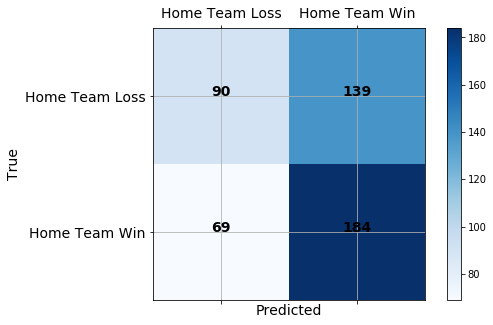

In [384]:
fig = plot_confusion_matrix(y_test,pred)

In [385]:
fig.savefig('images/cm.png')

In [388]:
from sklearn.dummy import DummyClassifier

In [389]:
dummy_frequent = DummyClassifier(strategy='most_frequent')
dummy_stratified = DummyClassifier(strategy='stratified')

In [390]:
for dum in [dummy_frequent,dummy_stratified]:
    dum.fit(X,y)


In [391]:
dummy_freq_preds = dummy_frequent.predict(X_test)
dummy_strat_preds = dummy_stratified.predict(X_test)

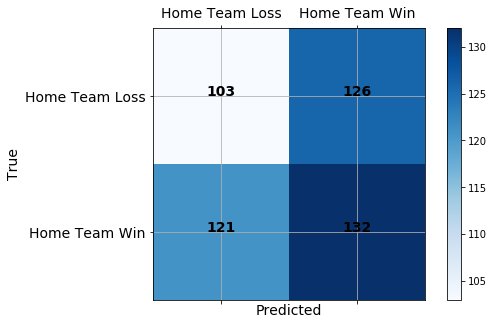

In [394]:
fig = plot_confusion_matrix(y_test,dummy_strat_preds)

In [402]:
dummy_report = pd.DataFrame(classification_report(y_test,dummy_strat_preds,output_dict=True))
my_report = pd.DataFrame(classification_report(y_test,pred,output_dict=True))

In [415]:
dummy_report

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.459821,0.511628,0.487552,0.485725,0.487014
recall,0.449782,0.521739,0.487552,0.485760,0.487552
f1-score,0.454746,0.516634,0.487552,0.485690,0.487231
support,229.000000,253.000000,0.487552,482.000000,482.000000


In [416]:
my_report

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.566038,0.569659,0.568465,0.567849,0.567939
recall,0.393013,0.727273,0.568465,0.560143,0.568465
f1-score,0.463918,0.638889,0.568465,0.551403,0.555759
support,229.000000,253.000000,0.568465,482.000000,482.000000
